In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from keras.layers import (
    Dense,
    Flatten,
    Dropout,
    Input,
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    confusion_matrix,
    f1_score,
)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob as gb
import cv2
from tqdm import tqdm
from collections import Counter
from sklearn.model_selection import train_test_split
from keras.applications import resnet

In [2]:
shape = (150, 150, 3)
image_size = 150
path = "./Images/"

In [3]:
def read_images_from_directory(
    folder_path,
    desc,
):
    images = []
    labels = []

    for folder in os.listdir(folder_path):
        files = gb.glob(pathname=str(folder_path + "/" + folder + "/*.jpg"))

        for file in tqdm(files, desc=desc + " in " + folder):
            image = plt.imread(file)
            img_resized = cv2.resize(image, (image_size, image_size))
            img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)
            images.append(img_rgb)
            labels.append(folder)

    return images, labels

In [4]:
x, y = read_images_from_directory(path, "Loading Training Data")

Loading Training Data in pituitary_tumor: 100%|██████████| 4504/4504 [00:24<00:00, 186.10it/s]


In [5]:
x_data = np.array(x)
len(x_data)

18818

In [6]:
lb = LabelBinarizer()
y_data = lb.fit_transform(y)

In [7]:
from sklearn.model_selection import train_test_split

x_temp, x_test, y_temp, y_test = train_test_split(
    x_data, y_data, test_size=0.2, random_state=42
)

In [8]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_no = 1
acc_per_fold = []
loss_per_fold = []

In [9]:
def create_model():
    model = Sequential()
    model.add(Input(shape=shape))

    base_model = resnet.ResNet50(
        include_top=False, input_shape=shape, weights="imagenet"
    )

    for layer in base_model.layers:
        layer.trainable = False

    model.add(base_model)
    model.add(Flatten())
    model.add(Dense(512, activation="relu"))
    model.add(Dropout(0.3))
    model.add(Dense(4, activation="softmax"))

    model.compile(
        optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
    )
    # model.summary()
    return model

In [10]:
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 5, 5, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 51200)             0         
                                                                 
 dense (Dense)               (None, 512)               26214912  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 2052      
                                                                 
Total params: 49,804,676
Trainable params: 26,216,964
Non-trainable params: 23,587,712
_________________________________________________________________


In [11]:
from tensorflow.keras.callbacks import EarlyStopping

earlystop = EarlyStopping(
    monitor="val_loss", min_delta=0, patience=10, verbose=1, restore_best_weights=True
)

In [12]:
for train_index, val_index in kf.split(x_temp):
    x_train_fold, x_val_fold = x_temp[train_index], x_temp[val_index]
    y_train_fold, y_val_fold = y_temp[train_index], y_temp[val_index]

    resnetss01 = create_model()

    print(f"Training fold {fold_no}...")
    history01 = resnetss01.fit(
        x_train_fold,
        y_train_fold,
        batch_size=32,
        validation_data=(x_val_fold, y_val_fold),
        epochs=50,
        callbacks=earlystop,
    )

    scores = resnetss01.evaluate(x_val_fold, y_val_fold, verbose=0)
    print(
        f"Score for fold {fold_no}: {resnetss01.metrics_names[0]} of {scores[0]}; {resnetss01.metrics_names[1]} of {scores[1]*100}%"
    )
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    fold_no += 1

    print(acc_per_fold)
    print(loss_per_fold)

Training fold 1...
Epoch 1/50
377/377 [==============================] - 43s 85ms/step - loss: 2.2625 - accuracy: 0.7583 - val_loss: 0.3544 - val_accuracy: 0.8579
Epoch 2/50
377/377 [==============================] - 30s 79ms/step - loss: 0.3595 - accuracy: 0.8636 - val_loss: 0.2957 - val_accuracy: 0.8907
Epoch 3/50
377/377 [==============================] - 29s 78ms/step - loss: 0.2654 - accuracy: 0.8950 - val_loss: 0.2285 - val_accuracy: 0.9153
Epoch 4/50
377/377 [==============================] - 29s 78ms/step - loss: 0.2083 - accuracy: 0.9196 - val_loss: 0.2507 - val_accuracy: 0.9150
Epoch 5/50
377/377 [==============================] - 29s 78ms/step - loss: 0.1971 - accuracy: 0.9264 - val_loss: 0.2303 - val_accuracy: 0.9263
Epoch 6/50
377/377 [==============================] - 30s 78ms/step - loss: 0.1610 - accuracy: 0.9376 - val_loss: 0.3241 - val_accuracy: 0.8970
Epoch 7/50
377/377 [==============================] - 30s 79ms/step - loss: 0.1535 - accuracy: 0.9444 - val_loss: 0.2

In [13]:
# Print overall results
print("Average scores for all folds:")
print(f"> Accuracy: {np.average(acc_per_fold)}")
print(f"> Loss: {np.average(loss_per_fold)}")

print("Scores per fold:")
for i in range(len(acc_per_fold)):
    print(f"> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%")

Average scores for all folds:
> Accuracy: 92.81922459602356
> Loss: 0.21930547654628754
Scores per fold:
> Fold 1 - Loss: 0.2260897308588028 - Accuracy: 93.82265210151672%
> Fold 2 - Loss: 0.22029206156730652 - Accuracy: 92.06243753433228%
> Fold 3 - Loss: 0.23425929248332977 - Accuracy: 91.43142104148865%
> Fold 4 - Loss: 0.21014128625392914 - Accuracy: 93.35768818855286%
> Fold 5 - Loss: 0.20574501156806946 - Accuracy: 93.4219241142273%


In [14]:
import numpy as np


def plot_training_curves(history):
    loss = np.array(history.history["loss"])
    val_loss = np.array(history.history["val_loss"])

    accuracy = np.array(history.history["accuracy"])
    val_accuracy = np.array(history.history["val_accuracy"])

    epochs = range(len(history.history["loss"]))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # plot loss
    ax1.plot(epochs, loss, label="traing_loss", marker="o")

    ax1.plot(epochs, val_loss, label="val_loss", marker="o")

    ax1.fill_between(
        epochs,
        loss,
        val_loss,
        where=(loss > val_loss),
        color="C0",
        alpha=0.3,
        interpolate=True,
    )
    ax1.fill_between(
        epochs,
        loss,
        val_loss,
        where=(loss < val_loss),
        color="C1",
        alpha=0.3,
        interpolate=True,
    )

    ax1.set_title("Loss", fontsize=16)
    ax1.set_xlabel("Epochs", fontsize=10)

    ax1.legend()

    # plot Accuracy
    ax2.plot(epochs, accuracy, label="traing_accuracy", marker="o")

    ax2.plot(epochs, val_accuracy, label="val_accuracy", marker="o")

    ax2.fill_between(
        epochs,
        accuracy,
        val_accuracy,
        where=(accuracy > val_accuracy),
        color="C0",
        alpha=0.3,
        interpolate=True,
    )
    ax2.fill_between(
        epochs,
        accuracy,
        val_accuracy,
        where=(accuracy < val_accuracy),
        color="C1",
        alpha=0.3,
        interpolate=True,
    )

    ax2.set_title("Accuracy", fontsize=16)
    ax2.set_xlabel("Epochs", fontsize=10)

    ax2.legend()

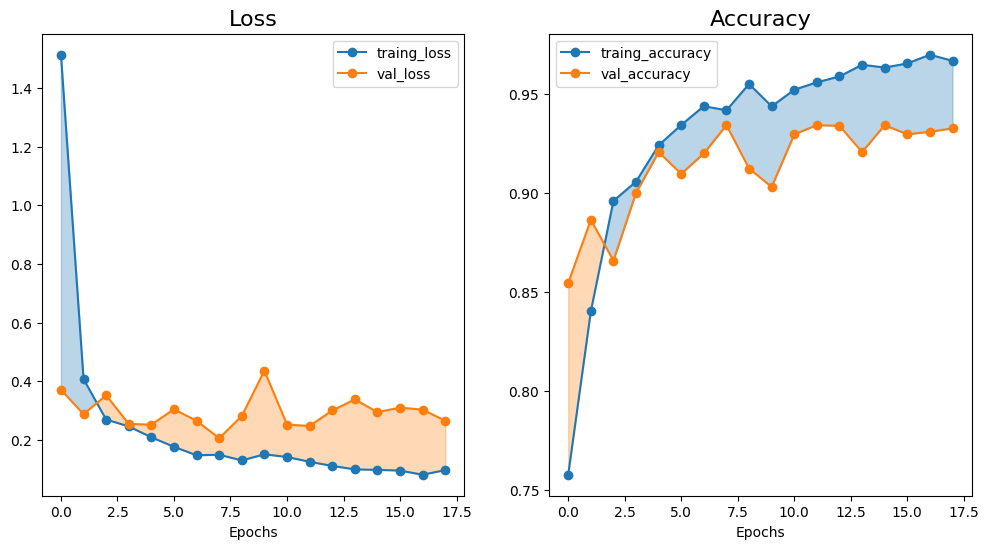

In [15]:
plot_training_curves(history01)

In [16]:
test_loss, test_acc = resnetss01.evaluate(x_data, y_data)
print(f"Test accuracy: {test_acc}")
print(f"Test loss: {test_loss}")

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [17]:
y_pred_probs = resnetss01.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

118/118 [==============================] - 8s 59ms/step


In [18]:
accuracy = accuracy_score(y_true, y_pred)

precision = precision_score(y_true, y_pred, average="weighted")

recall = recall_score(y_true, y_pred, average="weighted")

f1 = f1_score(y_true, y_pred, average="weighted")

In [19]:
print(f"Accuracy: {accuracy}")

print(f"Precision: {precision}")

print(f"Recall: {recall}")

print(f"F1 Score: {f1}")

Confusion Matrix:
[[844  58  14   2]
 [ 83 826  14  38]
 [  6  12 974   4]
 [  7  50   4 828]]
Accuracy: 0.922422954303932
Precision: 0.9223709759251904
Recall: 0.922422954303932
F1 Score: 0.9223250864163745


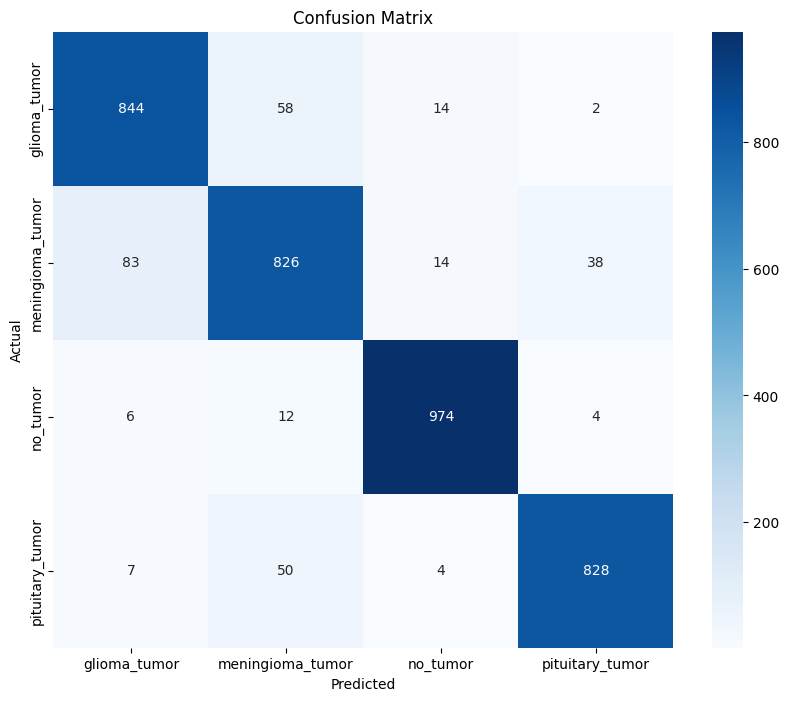

In [20]:
plt.figure(figsize=(10, 8))


sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=lb.classes_,
    yticklabels=lb.classes_,
)


plt.xlabel("Predicted")


plt.ylabel("Actual")


plt.title("Confusion Matrix")


plt.show()

In [21]:
model_directory = "Models"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)
model_path = os.path.join(model_directory, "ResNet50_AUG_K_Fold_01(150x150).h5")
resnetss01.save(model_path)
print(f"Model saved to {model_path}")

Model saved to Models\ResNet50_AUG_K_Fold_01(150x150).h5


In [9]:
def create_model():
    model = Sequential()
    model.add(Input(shape=shape))

    base_model = resnet.ResNet50(
        include_top=False, input_shape=shape, weights="imagenet"
    )

    model.add(base_model)
    model.add(Flatten())
    model.add(Dense(512, activation="relu"))
    model.add(Dropout(0.3))
    model.add(Dense(4, activation="softmax"))

    model.compile(
        optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
    )
    # model.summary()
    return model

In [10]:
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 5, 5, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 51200)             0         
                                                                 
 dense (Dense)               (None, 512)               26214912  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 2052      
                                                                 
Total params: 49,804,676
Trainable params: 49,751,556
Non-trainable params: 53,120
_________________________________________________________________


In [11]:
from tensorflow.keras.callbacks import EarlyStopping

earlystop = EarlyStopping(
    monitor="val_loss", min_delta=0, patience=10, verbose=1, restore_best_weights=True
)

In [12]:
for train_index, val_index in kf.split(x_temp):
    x_train_fold, x_val_fold = x_temp[train_index], x_temp[val_index]
    y_train_fold, y_val_fold = y_temp[train_index], y_temp[val_index]

    resnetss01 = create_model()

    print(f"Training fold {fold_no}...")
    history01 = resnetss01.fit(
        x_train_fold,
        y_train_fold,
        batch_size=32,
        validation_data=(x_val_fold, y_val_fold),
        epochs=50,
        callbacks=earlystop,
    )

    scores = resnetss01.evaluate(x_val_fold, y_val_fold, verbose=0)
    print(
        f"Score for fold {fold_no}: {resnetss01.metrics_names[0]} of {scores[0]}; {resnetss01.metrics_names[1]} of {scores[1]*100}%"
    )
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    fold_no += 1

    print(acc_per_fold)
    print(loss_per_fold)

Training fold 1...
Epoch 1/50
377/377 [==============================] - 113s 252ms/step - loss: 1.0263 - accuracy: 0.8072 - val_loss: 1.5404 - val_accuracy: 0.6157
Epoch 2/50
377/377 [==============================] - 92s 244ms/step - loss: 0.3298 - accuracy: 0.9025 - val_loss: 4.0599 - val_accuracy: 0.5530
Epoch 3/50
377/377 [==============================] - 94s 250ms/step - loss: 0.2821 - accuracy: 0.9159 - val_loss: 1.6412 - val_accuracy: 0.5334
Epoch 4/50
377/377 [==============================] - 92s 244ms/step - loss: 0.2135 - accuracy: 0.9325 - val_loss: 2.5169 - val_accuracy: 0.6579
Epoch 5/50
377/377 [==============================] - 84s 223ms/step - loss: 0.1645 - accuracy: 0.9484 - val_loss: 8.8860 - val_accuracy: 0.3278
Epoch 6/50
377/377 [==============================] - 90s 240ms/step - loss: 0.1424 - accuracy: 0.9552 - val_loss: 2.1478 - val_accuracy: 0.6137
Epoch 7/50
377/377 [==============================] - 92s 245ms/step - loss: 0.2122 - accuracy: 0.9390 - val_l

ResourceExhaustedError: Graph execution error:

Detected at node 'sequential_2/resnet50/conv3_block1_0_conv/Conv2D' defined at (most recent call last):
    File "c:\Anaconda\envs\tgpu\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Anaconda\envs\tgpu\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "c:\Anaconda\envs\tgpu\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "c:\Anaconda\envs\tgpu\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "c:\Anaconda\envs\tgpu\lib\site-packages\ipykernel\kernelapp.py", line 739, in start
      self.io_loop.start()
    File "c:\Anaconda\envs\tgpu\lib\site-packages\tornado\platform\asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "c:\Anaconda\envs\tgpu\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "c:\Anaconda\envs\tgpu\lib\asyncio\base_events.py", line 1909, in _run_once
      handle._run()
    File "c:\Anaconda\envs\tgpu\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Anaconda\envs\tgpu\lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue
      await self.process_one()
    File "c:\Anaconda\envs\tgpu\lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one
      await dispatch(*args)
    File "c:\Anaconda\envs\tgpu\lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell
      await result
    File "c:\Anaconda\envs\tgpu\lib\site-packages\ipykernel\ipkernel.py", line 359, in execute_request
      await super().execute_request(stream, ident, parent)
    File "c:\Anaconda\envs\tgpu\lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request
      reply_content = await reply_content
    File "c:\Anaconda\envs\tgpu\lib\site-packages\ipykernel\ipkernel.py", line 446, in do_execute
      res = shell.run_cell(
    File "c:\Anaconda\envs\tgpu\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Anaconda\envs\tgpu\lib\site-packages\IPython\core\interactiveshell.py", line 3075, in run_cell
      result = self._run_cell(
    File "c:\Anaconda\envs\tgpu\lib\site-packages\IPython\core\interactiveshell.py", line 3130, in _run_cell
      result = runner(coro)
    File "c:\Anaconda\envs\tgpu\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Anaconda\envs\tgpu\lib\site-packages\IPython\core\interactiveshell.py", line 3334, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Anaconda\envs\tgpu\lib\site-packages\IPython\core\interactiveshell.py", line 3517, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Anaconda\envs\tgpu\lib\site-packages\IPython\core\interactiveshell.py", line 3577, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Ziad Thabet\AppData\Local\Temp\ipykernel_6380\1256382896.py", line 8, in <module>
      history01 = resnetss01.fit(
    File "c:\Anaconda\envs\tgpu\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Anaconda\envs\tgpu\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Anaconda\envs\tgpu\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\Anaconda\envs\tgpu\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Anaconda\envs\tgpu\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\Anaconda\envs\tgpu\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "c:\Anaconda\envs\tgpu\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Anaconda\envs\tgpu\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Anaconda\envs\tgpu\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Anaconda\envs\tgpu\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Anaconda\envs\tgpu\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Anaconda\envs\tgpu\lib\site-packages\keras\engine\sequential.py", line 410, in call
      return super().call(inputs, training=training, mask=mask)
    File "c:\Anaconda\envs\tgpu\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Anaconda\envs\tgpu\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Anaconda\envs\tgpu\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Anaconda\envs\tgpu\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Anaconda\envs\tgpu\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Anaconda\envs\tgpu\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Anaconda\envs\tgpu\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Anaconda\envs\tgpu\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Anaconda\envs\tgpu\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Anaconda\envs\tgpu\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Anaconda\envs\tgpu\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Anaconda\envs\tgpu\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Anaconda\envs\tgpu\lib\site-packages\keras\layers\convolutional\base_conv.py", line 283, in call
      outputs = self.convolution_op(inputs, self.kernel)
    File "c:\Anaconda\envs\tgpu\lib\site-packages\keras\layers\convolutional\base_conv.py", line 255, in convolution_op
      return tf.nn.convolution(
Node: 'sequential_2/resnet50/conv3_block1_0_conv/Conv2D'
OOM when allocating tensor with shape[32,512,19,19] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node sequential_2/resnet50/conv3_block1_0_conv/Conv2D}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_70864]

In [ ]:
# Print overall results
print("Average scores for all folds:")
print(f"> Accuracy: {np.average(acc_per_fold)}")
print(f"> Loss: {np.average(loss_per_fold)}")

print("Scores per fold:")
for i in range(len(acc_per_fold)):
    print(f"> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%")

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history01.history["loss"], label="Training Loss")
plt.plot(history01.history["val_loss"], label="Validation Loss")
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history01.history["accuracy"], label="Training Accuracy")
plt.plot(history01.history["val_accuracy"], label="Validation Accuracy")
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

In [ ]:
test_loss, test_acc = resnetss01.evaluate(x_test, y_test)
print(f"Test accuracy: {test_acc}")
print(f"Test loss: {test_loss}")

In [ ]:
y_pred_probs = resnetss01.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

In [ ]:
conf_matrix = confusion_matrix(y_true, y_pred)

accuracy = accuracy_score(y_true, y_pred)


precision = precision_score(y_true, y_pred, average="weighted")


recall = recall_score(y_true, y_pred, average="weighted")


f1 = f1_score(y_true, y_pred, average="weighted")

print(f"Accuracy: {accuracy}")

print(f"Precision: {precision}")

print(f"Recall: {recall}")

print(f"F1 Score: {f1}")

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=lb.classes_,
    yticklabels=lb.classes_,
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
model_directory = "Models"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)
model_path = os.path.join(model_directory, "ResNet50_AUG_K_Fold_02(150x150).h5")
resnetss01.save(model_path)
print(f"Model saved to {model_path}")